# Modeling Demand for Cars with the Similarity Model

In this notebook, we will explore the dataset used in
Brownstone and Train (1999). We will estimate the Similarity Model
model given the available data using the functions defined below.


In [1]:
import numpy as np
import pandas as pd 
import os
from numpy import linalg as la
from scipy import optimize
from IPython import display
from matplotlib import pyplot as plt
import itertools as iter

# Files
import Logit_file as logit

Data
====

The data consists of a survey of households regarding their preferences
for car purchase. Each household was given 6 options, but the
characteristics that the respondents were asked about was varied. The
surveys were originally conducted in order to illicit consumer
preferences for alternative-fuel vehicles. The data is *stated
preferences*, in the sense that consumers did not actually buy but just
stated what they would hypothetically choose, which is of course a
drawback. This is very common in marketing when historic data is either
not available or does not provide satisfactory variation. The advantage
of the stated preference data is therefore that the choice set can be
varied greatly (for example, the characteristics includes the
availability of recharging stations, which is important for purchase of
electric cars).

The data has $N=4654$ respondents with $J=6$ cars to choose
from.

Loading the dataset, `car_data.csv`, we get a dataframe with 
$NJ = 27,924$ rows. The column `person_id` runs through $0,1,...,N-1$, and
the column `j` is the index for the car, $\{0,1,...,5\}$. The variable 
`binary_choice` is a dummy, =1 for the car chosen by the respondent. 
A conveneint other variable, `y`, is the index for that car, repeated 
and identical for all $J$ rows for each person. The x-variables describe 
the characteristics of the 6 cars that the respondent was asked to choose 
from. 

We also read in the dataset `car_labels.csv`, which contains the 
variable labels and descriptions for all the variables. 
The lists `x_vars` and `x_lab` will be used throughout as the list of 
explanatory variables we want to work with. 

In order to get the data into a 3-dimensional array, we access 
the underlying numpy arrays and resize them. For example 

> `x = dat[x_vars].values.resize((N,J,K))`

Note that this will only work because the data is sorted according to 
first `person_id` and then `j`. You can test this by verifying that 
`x[0,:,k]` prints the same as `dat.loc[dat.person_id == 0, x_vars[k]]`. 

In [2]:
# Load dataset and variable names
os.chdir('../GREENCAR_notebooks/')
input_path = os.getcwd() # Assigns input path as current working directory (cwd)
dat = pd.read_csv(os.path.join(input_path, 'car_data.csv'))
lab = pd.read_csv(os.path.join(input_path, 'car_labels.csv'), index_col = 'variable')

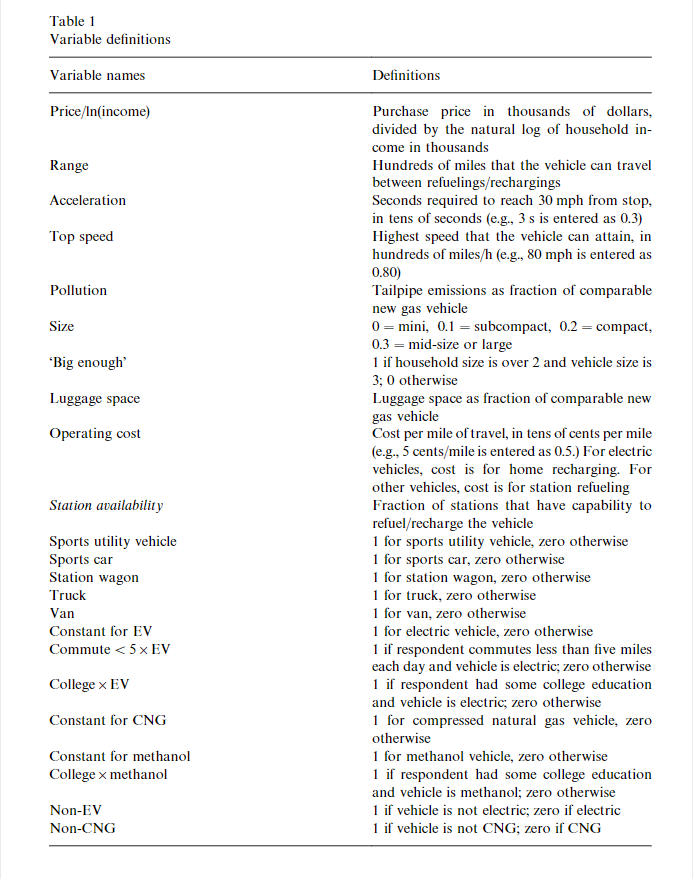

In [3]:
display.Image('brownstone_train_tab_1.PNG')

Table 1 from 'Forecasting new product penetration with flexible substitution patterns (1999), D. Brownstone, K. Train'

## Scaling variables

To be consistent with the interpretation of estimates in 'Brownstone & Train (1999)' we rescale some of the explanatory variables. Furthermore, Logit models are most stable numerically if we ensure that variables are scaled near to $\pm 1$. 

In [4]:
dat['range'] = dat['range'] / 100                  # Hundreds of miles that the vehicle can travel between fuelings
dat['top_speed'] = dat['top_speed'] / 100          # Highest speed that the vehicle can attain, in hundreds of miles per hour
dat['size'] = dat['size'] / 10                     # Scaled categorical variable for numerical purposes
dat['acceleration'] = dat['acceleration'] / 10     # Measured in tens of seconds
dat['operating_cost'] = dat['operating_cost'] / 10 # Measured in tens of cents per mile

Since, respectively, 'EV'and 'Non-EV'and 'CNG' and 'Non-CNG' are equivalent we exclude the latter and keep all the other characteristics as explanatory variables.  

In [5]:
# variables to use as explanatory variables
x_vars = list(lab.iloc[3:-4].index.values) # variable names

In [6]:
# dimensions of data
N = dat.person_id.nunique()
J = dat.j.nunique()
K = len(x_vars)

Finally, we will primarily use numpy data types and numpy functions in this notebook. Hence we store our response variable 'y' and our explanatory variables 'x' as numpy arrays.

In [7]:
# response and explanatory variables as numpy arrays
a = dat['y'].values.reshape((N,J))
a = a[:, 0] # All values are equal along axis=1. Becomes an (N,) array i.e. it is a vector.
y = pd.get_dummies(a).to_numpy() # Convert y to an (N,J) array as the onehot encoding
x = dat[x_vars].values.reshape((N,J,K))

#### Multinomial Logit - for comparison
Estimating a Logit model via maximum likelihood with an initial guess of parameters $\hat \beta^0 = 0$ yields estimated parameters $\hat \beta^{\text{logit}}$ given as...

In [8]:
beta_0 = np.zeros((K,))

# Estimate the model
res_logit = logit.estimate_logit(logit.q_logit, beta_0, a, x)

TypeError: estimate_logit() missing 1 required positional argument: 'sample_share'

In [ ]:
logit_beta = res_logit['beta']
pd.DataFrame(logit_beta.reshape(1,len(logit_beta))) # Our estimates

0         1         2         3         4         5         6   \
0 -0.185425  0.350097 -0.716186  0.261102 -0.444102  0.934359  0.143349   

         7         8         9   ...       11        12        13       14  \
0  0.502492 -0.767961  0.413064  ...  0.63611 -1.436669 -1.016813 -0.79894   

         15        16        17        18        19        20  
0 -0.179022  0.198374  0.442935  0.345063  0.313123  0.228548  

[1 rows x 21 columns]

We then compute the corresponding Logit choice probabilities

In [ ]:
logit_q = logit.logit_ccp(logit_beta, x)

Implemented on our datset, we find the elasticities and diversion ratios as follows...

In [ ]:
epsilon_logit = logit.logit_elasticity(logit_q, logit_beta, 0)
DR_logit_hat = logit.logit_diversion_ratio(logit_q, logit_beta)

# Similarity Model

### Nests of cars
In our case, we construct nests along the dimensions of 'Fuel Type' and 'Body Type' as suggested by the figure below. Each alternative is assigned to two nests: One representing fuel type (Electric, Combustion/Natural Gas , Methanol) and one representing body type (Car, Truck/Van).

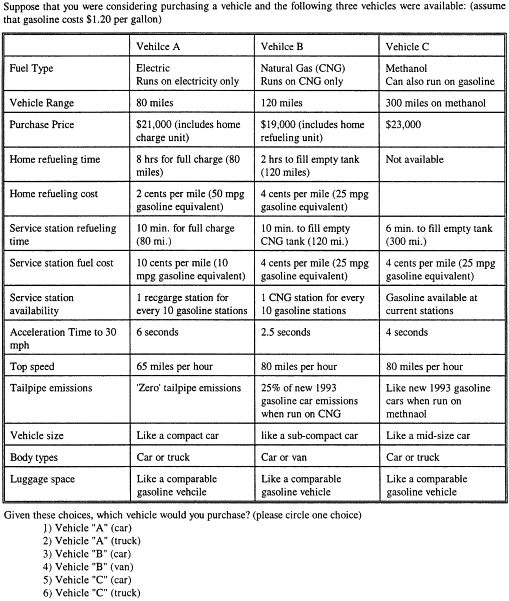

In [ ]:
display.Image('brownstone_train_fig_1.gif')

Figure 1 from 'Forecasting new product penetration with flexible substitution patterns (1999), D. Brownstone, K. Train'

# The Similarity model - Nesting structure

The Similarity model is a generalization of the IPDL and the nested logit model where each alternative may belong partially to multiple nests and where, amongst other things, nesting parameters may be negative. Before fully introducing the model, we construct the nesting structure.


## Constructing nests

Let $\Delta=\left\{q\in \mathbb{R}^J_+: \sum_{j=1}^J q_j=1\right\}$ denote the probability simplex. The degree of association for products $\mathcal{J} = \{1,\ldots,J\}$ with characteristics $\mathcal{C}=\{1,\ldots,C\}$ for each individual $i$ is given by the 'Similarity Matrix' $\Psi = \{\psi_{cj}\}_{c\in\mathcal{C},j\in\mathcal{J}}\in \mathbb R^{C\times J}$ such that $\psi_{cj} \geq 0$ is the degree to which product $j$ is associated with characteristic $c$, and the column $\Psi_{j} = (\psi_{1j}, \ldots, \psi_{Cj})'$ is a probability distribution over characteristics for product $j$, meaning that $\sum_{c=1}^{C}\psi_{cj}=1$ for all $j$. The matrix-vector product $\Psi q$ is then
$$
\Psi q=\sum_j \Psi_{j}q_j=\left(\begin{array}{c}
\sum_{j:\psi_{1j}>0} \psi_{1j}q_j \\
\vdots \\
\sum_{j: \psi_{Cj}>0}\psi_{Cj}q_j
\end{array}\right),
$$
and the vector $\Psi q$ is a vector of charateristic-specific choice probabilities, i.e. the sum of the weighted probabilities within each charateristic $c\in\mathcal{C}$. 

Following 'Fosgerau & Nielsen (2023)' we model the Similarity matrix $\Psi$ as a logit specification of the characteristics $X_i \in \mathbb{R}^{C\times J}$ for individual $i$:

$$
\psi_{cj}(X_i, \gamma) = \frac{e^{X_{cj} \gamma_c}}{\sum_{c'=1}^{C} e^{X_{ic'j} \gamma_{c'}}}
$$

for all $c$ and all $j$. Here $\gamma = (\gamma_1, \ldots, \gamma_{C})'$ is a vector of parameters to be estimated. 

## The Similarity perturbation function $\Omega$

In the following, a vector $z\in \mathbb R^d$ is always a column vector. We now construct the Similarity perturbation function $\Omega: \Delta \to \mathbb{R}$ which has the form (where for a vector $z$, the logarithm is applied elementwise and $z'$ denote the transpose)
$$
\Omega(q|\eta)= q'\ln q - \sum_{c=1}^{C} \eta_c \sum_{j=1}^J \psi_{cj} q_j \ln \left(\frac{\psi_{cj} q_j}{\sum_{j' = 1}^J \psi_{cj'} q_{j'}}\right).
$$

where $\eta = (\eta_1, \ldots, \eta_C)' \in \mathbb{R}^C$ is a vector of parameters associated with characteristics $\mathcal{C}$, which has the property that $\sum_{c\in \mathcal{C}^+} \eta_c \psi_{cj} < 1$ for all products $j$, where $\mathcal{C}^+ = \{c\in \mathcal{C} | \eta_c \geq 0\}$ is the set of characteristics with an associated nonnegative parameter $\eta_c$. This latter condition ensures that the Similarity pertubation $\Omega(\cdot | \eta )$ is strictly convex. Note furthermore, when $\eta = 0$ the Similarity model becomes the standard multinomial Logit model.

It will be convenient to define a choice probability function for a given vector of payoffs $u$ as
$$
P(u|\lambda)=\arg \max_{q\in \Delta}q'u-\Omega(q|\lambda).
$$
Letting $\theta$ denote the full vector of parameters, $\theta=(\beta',\eta', \gamma')'$, the individual choice probabilities are a function of the matrix $\mathbf{X}_i$ and the parameters $\theta$, as
$$
p(\mathbf{X}_i,\theta)=\arg\max_{q\in \Delta}q'\mathbf{X}_i \beta-q'\ln q + \sum_{c=1}^{C} \eta_c \sum_{j=1}^J \psi_{cj} q_j \ln \left(\frac{\psi_{cj} q_j}{\sum_{j' = 1}^J \psi_{cj'} q_{j'}}\right)
$$

In [ ]:
def calc_Psi(gamma, X, MAXRESCALE:bool=True):
    '''
    This function calculates the charaterstic matrices \Psi^g
    
    Args.
        gamma: a (K,) numpy array of parameters
        X: a (N,C,J) numpy array of characteristics for products

    Returns
        Psi: a (N,C,J) array of characteristic weights \psi_{cj} for each individual i
    '''

    # X_{ijc} @ \gamma_c matrix product 
    v = np.einsum('ncj,c->ncj', X, gamma) # (N,J,C) 

    if MAXRESCALE: 
        # subtract the row-max from each observation
        v -= v.max(axis=1, keepdims=True)  # keepdims maintains the second dimension of (N,C,J), so broadcasting is successful
    
    # denominator 
    denom = np.exp(v).sum(axis=1, keepdims=True) # (N,1,J)
    
    # Logit characteristics
    Psi = np.exp(v) / denom

    return Psi

### How to do 'characteristics' vs. just all explanatory variables ???

In [ ]:
chars =  [*range(10,15+1),*range(18,19+1)]  # car vs. truck/van + ev vs. cng vs. methanol variables --- [*np.arange(K)]

X = np.einsum('njk->nkj',x)[:,chars,:] # Get relevant characteristics - Maybe reduce no. of characteristics to 5 like in IPDL nests?
C = X.shape[1]
gamma = .2*np.ones((X.shape[1],))
Psi = calc_Psi(gamma, X)
pd.DataFrame(Psi[0,:,:])

0         1         2         3         4         5
0  0.118444  0.121634  0.118444  0.118444  0.121634  0.121634
1  0.118444  0.121634  0.118444  0.118444  0.121634  0.121634
2  0.118444  0.121634  0.118444  0.144668  0.121634  0.121634
3  0.118444  0.121634  0.118444  0.118444  0.121634  0.148564
4  0.144668  0.121634  0.144668  0.118444  0.148564  0.121634
5  0.118444  0.121634  0.118444  0.118444  0.121634  0.121634
6  0.144668  0.148564  0.118444  0.118444  0.121634  0.121634
7  0.118444  0.121634  0.144668  0.144668  0.121634  0.121634

## Model solution

While it is possible to solve for the choice probabilities explicitly by maximizing utility, Fosgerau and Nielsen (2021) suggest a contraction mapping approach which is conceptually simpler. 

Suppose we are evaluating the likelihood at some guess of the parameters $\theta=(\beta',\eta', \gamma')$. Let $u_i = \mathbf{X}_i \beta$ be the deteministic part of utility for some parameters $\beta \in \mathbb{R}^K$, and let $ q^0_i = \frac{e^{u_i}}{\sum_{j\in\mathcal{J}} e^{u_ij}}$ denote the corresponding initial vector of choice probabilities. Furthermore, let the positive numbers $\epsilon,\delta \geq 0$ be given by $\epsilon \equiv \max_{j\in \mathcal{J}}\{ \sum_{c\in \mathcal{C}^+}  \psi_{cj} \eta_c < 1\}$ and $\delta \equiv \max_{j\in \mathcal{J}}\{ \sum_{c\in \mathcal{C}^-} \psi_{cj}|\eta_c| < 1\}$, where $\mathcal{C}^- = \{c\in \mathcal{C} | \eta_c < 0\}$ is the set of characteristics with negative associated parameters, and set $\mu \equiv \frac{\epsilon + \delta}{1+ \delta} \in [0,1)$. 

Then for each iteration $k\in \mathbb{N}$ we update the choice probabilities as follows:

$$
v_{ij}^k =  \frac{1}{1+\delta}\left(u_{ij} - \ln(q_{ij}^{k-1}) + \sum_{c\in\mathcal{C}}\eta_c \psi_{cj} \ln\left(\frac{\psi_{cj} q_{ij}^{k-1}}{\sum_{\ell\in\mathcal{J}}\psi_{c\ell} q_{i\ell}^{k-1}}\right)\right)
$$
$$
q_{ij}^k = \frac{ q_{ij}^{k-1}  {e^{v_{ij}^k}}}{\sum_{\ell\in\mathcal{J}} q_{i\ell}^{k-1} e^{v_{i\ell}^k}}
$$

Fosgerau and Nielsen (2021) show that $\lim_{k\rightarrow \infty}q_i^k=p(\mathbf{X}_i,\theta)$ for any starting value $q^0_i$ in the interior of $\Delta$. For numerical stability, it can be a good idea to also do max-rescaling of $v^k_i$ at every iteration. Let $p$ denote the solution to the utility maximization problem. Formally, the mapping above satisfies the condition that the Kullback-Leibler divergence $D(p || q) = p'\ln(\frac{p}{q})$ decays linearly with each iteration $D(p || q^k) \leq \mu D(p || q^{k-1})$ with $\mu\in [0,1)$.

In [ ]:
def Similarity_ccp(theta, x, Psi, tol = 1.0e-15, maximum_iterations = 1000, MAXRESCALE:bool = True):
    ''' 
    This function computes the choice probabilities q

    Args.
        theta: a (K+2C,) numpy array of parameters
        x: a (N,J,K) numpy array of covariates
        Psi: a (N,C,J) numpy array of the psi_{cj} weights as outputted by the 'calc_Psi'-function
        tol: a float denoting the numeric degree of toleration before convergence is achieved. Default value is 1.0e^-15
        maximum_iterations: an integer which gives the highest acceptable number of iterations before the algorithm is forced to break
        MAXRESCALE: a boolean of whether or not to use max-rescaling in the computations

    Returns
        q1: a (N,J) numpy array of Similarity choice probabilities
    '''

    assert theta.ndim == 1
    assert x.ndim == 3
    assert Psi.ndim == 3

    N,J,K = x.shape
    C = Psi.shape[1]

    # Assign parameters
    beta = theta[:K]
    eta = theta[K:K+C]
    gamma = theta[K+C:]

    # Calculate \delta
    C_minus = np.where(eta < 0, -eta, 0) 
    delta = np.max(np.einsum('ncj,c->nj', Psi, C_minus), axis=1)

    # Compute deterministic utilities 'u' and set initial guess of choice probabilities to logit choice probabilities
    u = np.einsum('njk,k->nj', x, beta)
    q = logit.logit_ccp(beta, x)
    q0 = q

    assert q.ndim == 2

    for k in np.arange(maximum_iterations):
        
        # Construct 'v' term
        denom_frac_psiq = np.einsum('ncj,nj->nc', Psi, q0)  # Is an ordinary matrix/vector product. Computes denominator in the latter logarithm-term
        numer_frac_psiq = np.einsum('ncj,nj->ncj', Psi, q0)  # Is an elementwise product. Computes the numerator in the latter logarithm-term. Equivalent to Psi * q0[:,None,:] 
        log_frac_psiq = np.log(np.einsum('ncj,nc->ncj', numer_frac_psiq, 1./denom_frac_psiq)) # Computes the latter logarithm-term. Is an elementwise product
        sum_eta_psi_log = np.einsum('c,ncj,ncj->nj', eta, Psi, log_frac_psiq) # First computes elementwise product of psi and the log factor, then ordinary matrix product w. eta
        v_numer = u - np.log(q0) + sum_eta_psi_log # Compute the expression in parantheses i.e. the numerator of v
        v = np.einsum('nj,n->nj', v_numer, 1./(1 + delta)) # divide by 1+\delta

        if MAXRESCALE:
            v -= v.max(axis=1, keepdims = True) # keeps the last dimension so it is (N,J)

        # Compute updated choice probability
        q1_numer = q0 * np.exp(v) # Computes elementwise product. Numerator in q
        q1_denom = np.einsum('nj,nj->n', q0, np.exp(v)) # Computes matrix product. Denominator in q
        q1 = np.einsum('nj,n->nj', q1_numer, 1./q1_denom) # Computes the new iteration of q

        # Check for convergence in an appropriate distance
        dist = np.max(np.sum((q1-q0)**2/q , axis=1)) # Corrects for numerical errors when q1~q0~0 by normalising with logit probabilties.

        if dist<tol:
            break
        elif k==maximum_iterations:
            break
        else:
            None

        # Iteration step
        q0 = q1

    return q1

In [ ]:
eta = .1*np.ones((X.shape[1]))
theta = np.array([*logit_beta, *eta, *gamma])
ccp0 = Similarity_ccp(theta, x, Psi)
pd.DataFrame(ccp0)

0         1         2         3         4         5
0     0.133379  0.324051  0.210783  0.103800  0.127711  0.100275
1     0.242302  0.099750  0.298486  0.060500  0.225939  0.073023
2     0.199974  0.064625  0.240660  0.099073  0.328982  0.066686
3     0.128846  0.041640  0.165935  0.068314  0.494945  0.100320
4     0.077021  0.024891  0.160153  0.065930  0.558750  0.113255
...        ...       ...       ...       ...       ...       ...
4649  0.162642  0.052562  0.206097  0.084848  0.410622  0.083229
4650  0.223494  0.072226  0.338249  0.139246  0.188562  0.038223
4651  0.110580  0.140883  0.036510  0.022903  0.168301  0.520824
4652  0.047875  0.148167  0.276285  0.351976  0.107966  0.067730
4653  0.087936  0.036201  0.212982  0.043168  0.468354  0.151358

[4654 rows x 6 columns]

## Gradients and Hessians

The gradient and hessian of $\Omega$ are given by:

$$
\frac{\partial \Omega(q)}{\partial q_j} = \ln (q_j) - \sum_{c \in \mathcal{C}} \eta_c \psi_{cj} \ln \left( \frac{\psi_{cj} q_j}{\sum_{k\in\mathcal{J}} \psi_{ck} q_k} \right) + 1
$$
Which may be written compactly as:

$$
\nabla_q \Omega(q) = \ln(q)-\eta' \Psi \ln \left( \frac{1}{\Psi q} \circ \Psi' \circ q \right) + \iota
$$

Hence we obtain the following very useful cross derivatives:
$$
\frac{\partial^2 \Omega(q)}{\partial \eta_c \partial q_j} =  - \psi_{cj} \ln \left( \frac{\psi_{cj} q_j}{\sum_{k\in\mathcal{J}} \psi_{ck} q_k} \right)
$$
which may be written as:
$$
\nabla^2_{\eta q} \Omega(q) = -\left(\Psi \circ \ln \left( \frac{1}{\Psi q} \circ \Psi' \circ q \right)\right)'
$$

and also the derivative:
$$
\frac{\partial^2 \Omega(q)}{\partial \psi_{ck} \partial q_j} =  - \eta_c \left( 1_{\{j=k\}} \left[ \ln\left( \frac{\sum_{\ell \in \mathcal{J}} \psi_{c\ell} q_\ell }{\psi_{ck} q_k}\right) -1  \right] + \frac{\psi_{cj} q_k}{\sum_{\ell \in \mathcal{J}} \psi_{c\ell} q_\ell} \right)
$$

which may be written as derivative with respect to the rows of $\Psi$ as follows:

$$
\frac{\partial^2 \Omega(q)}{\partial \Psi_{(c)} \partial q_j} = -\eta_c\left( I_J \circ \left[\ln \left(   \frac{\Psi_{(c)} q}{\Psi_{(c)}' \circ q} \right) - \iota \right] + \frac{\psi_{cj} q}{\Psi_{(c)}  q} \right)
$$
Note also that we obtain the usual derivative of logit wrt. parameters for the columns of $\Psi$:

$$
\frac{\partial \Psi_{(j)}}{\partial \gamma} = \left(\mathrm{diag}(\Psi_{(j)}) - \Psi_{(j)}\Psi_{(j)}' \right) \circ \mathbf{X}_{(j)}
$$

Lastly the hessian wrt. choice probabilities of $\Omega$ is given by:

$$
\nabla_{qq}^2 \Omega (q) = \mathrm{diag}\left(\frac{\eta^0}{q}\right) + \Psi' \mathrm{diag}\left(\frac{\eta}{\Psi q}\right) \Psi
$$

where the ratio of vectors is understood to be the component-wise ratio, $\circ$ is the elementswise product of matrices, $\ln(A)$ is the logarithm applied elementwise to the entries of a matrix $A$, and $\eta^0 =  \iota - \Psi' \eta$ is a vector of strictly positive constants, since $1-\sum_{c\in\mathcal{C}} \psi_{ck} \eta_c \geq 1-\sum_{c\in\mathcal{C}^+} \psi_{ck} \eta_c > 0$. Fosgerau and Nielsen (2021) show that the hessian $ \nabla_{qq}^2 \Omega(q)$ is invertible.

## Maximum likelihood estimation of Similarity

The log-likelihood contribution is
$$
\ell_i(\theta)=y_i'\ln p(\mathbf{X}_i,\theta),
$$
and an estimation routine must therefore have a function that - given $\mathbf{X}_i$ and $\theta$ - calculates $u_i=\mathbf{X}_i\beta$ and constructs $\Gamma$, and then calls the fixed point routine described above. That routine will return $p(\mathbf{X}_i,\theta)$, and we can then evaluate $\ell_i(\theta)$. Using our above defined functions we now construct precisely such an estimation procedure.

For maximizing the likelihood, we want the derivates at some $\theta=(\beta',\eta', \gamma')$. Let $q_i=p(\mathbf{X}_i,\theta)$, then we have
$$
\nabla_\theta \ln p(\mathbf{X}_i,\theta)=\mathrm{diag}(q_i)^{-1}\left(\nabla_{qq}^2\Omega(q_i|\eta, \gamma)^{-1}-q_iq_i' \right)\left[\mathbf{X}_i,-\nabla_{\eta, q}^2 \Omega(q_i|\eta, \gamma), -\nabla_{\gamma, q}^2 \Omega(q_i|\eta, \gamma)\right]
$$
Note that the first two components is the elasticity $\nabla_u \ln P(u|\lambda)$ and the last term is a block matrix of size $J\times \dim(\theta)$. Note that the latter term of the cross-derivates of $\Omega$ wrt. parameters are given by respectively:

$$

$$

The derivative of the log-likelihood function can be obtained from this as
$$
\nabla_\theta \ell_i(\theta)=\nabla_\theta \ln p(\mathbf{X}_i,\theta)' y_i \\
$$

In [ ]:
def Similarity_loglikelihood(theta, y, x, X):
    ''' 
    This function computes the loglikelihood contributions \ell_i for each individual i

    Args.
        theta: a (K+2C,) numpy array of parameters
        y: a (N,J) numpy array of onehot encoded of response variables
        x: a (N,J,K) numpy array of covariates
        X: a (N,C,J) numpy array of characteristics for products

    Returns
        ll: a (N,) numpy array of loglikelihood contributions
    '''

    assert theta.ndim == 1
    assert x.ndim == 3
    assert y.ndim == 2
    assert X.ndim == 3

    N,J,K = x.shape
    C = X.shape[1]

    gamma = theta[K+C:]

    Psi = calc_Psi(gamma, X) # Find Psi
    ccp = Similarity_ccp(theta, x, Psi) # Find choice probabilties 

    ll = np.einsum('nj,nj->n', y, np.log(ccp)) # Find loglikelihood contributions

    return ll


In [ ]:
def q_Similarity(theta, y, x, X):
    ''' This function computes the likelihood criterion to be minimized
    '''
    return -Similarity_loglikelihood(theta, y, x, X)

We now calculate the derivative of the loglikelihood contributions $\ell_i(\theta)$ wrt. with respect to parameters $\theta=(\beta',\eta', \gamma')$.

In [ ]:
def Similarity_pertubation_hessian(theta, x, q, Psi):
    ''' 
    This function computes the hessian of \Omega wrt. choice probabilities q

    Args.
        theta: a (K+2C,) numpy array of parameters
        x: a (N,J,K) numpy array of covariates
        q: a (N,J) numpy array of Similarity choice probabilities
        Psi: a (N,C,J) numpy array of the psi_{cj} weights as outputted by the 'calc_Psi'-function

    Returns
        jac: a (N,J,J) array of second derivatives of the pertubation function \Omega wrt. q 
    ''' 

    assert theta.ndim == 1
    assert q.ndim == 2
    assert Psi.ndim == 3
    assert x.ndim == 3

    N,C,J = Psi.shape
    K = x.shape[2]

    Eta = theta[K:K+C]

    # Compute the first diagonal matrix term
    eta0 = np.ones((N,J)) - np.einsum('ncj,c->nj', Psi, Eta)
    diag_eta0_q = np.einsum('jk,nj->njk', np.eye(J), eta0/q) # Computes an outer product of the fraction eta0/q and a (J,J) identity matrix for each individual i

    # Compute the latter quadratic term
    Psi_q = np.einsum('ncj,nj->nc', Psi, q)
    eta_Psi_q = np.einsum('c,nc->nc', Eta, 1./Psi_q) # Computes elementwise product.
    diag_eta_Psi_q = np.einsum('cm,nc->ncm', np.eye((C)), eta_Psi_q) # Computes the middle diagonal matrix via an outer product with the (C,C) identity for each individual i
    Psi_diag_Psi = np.einsum('ncj,ncm,nmk->njk', Psi, diag_eta_Psi_q, Psi) # Computes the quadratic form

    jac = diag_eta0_q + Psi_diag_Psi # Sums the two terms

    return jac


In [ ]:
def Similarity_u_jac_ccp(theta, x, q, Psi):
    ''' 
    This function computes the jacobian of the choice probabilites wrt. the deterministic utilities u

    Args.
        theta: a (K+2C,) numpy array of parameters
        x: a (N,J,K) numpy array of covariates
        q: a (N,J) numpy array of Similarity choice probabilities
        Psi: a (N,C,J) numpy array of the psi_{cj} weights as outputted by the 'calc_Psi'-function

    Returns
        jac: a (N,J,J) numpy array of first derivatives of the choice probabilities wrt. utilities u
    '''

    assert theta.ndim == 1
    assert q.ndim == 2
    assert Psi.ndim == 3
    assert x.ndim == 3

    inv_pertubation_jac = la.inv(Similarity_pertubation_hessian(theta, x, q, Psi)) # Computes the inverse of each of the N (J,J) matrices in the Hessian 
    qqT = np.einsum('nj,nk->njk', q, q) # Computes an outer product
    jac = inv_pertubation_jac - qqT # Calculates the jacobian

    return jac

In [ ]:
def Similarity_u_jac_log_ccp(theta, x, q, Psi):
    ''' 
    This function computes the jacobian of the log of the choice probabilites wrt. the deterministic utilities u

    Args.
        theta: a (K+2C,) numpy array of parameters
        x: a (N,J,K) numpy array of covariates
        q: a (N,J) numpy array of Similarity choice probabilities
        Psi: a (N,C,J) numpy array of the psi_{cj} weights as outputted by the 'calc_Psi'-function

    Returns
        jac: a (N,J,J) numpy array of first derivatives of the log choice probabilities wrt. utilities u
    '''

    assert theta.ndim == 1
    assert q.ndim == 2
    assert Psi.ndim == 3
    assert x.ndim == 3

    u_grad_ccp = Similarity_u_jac_ccp(theta, x, q, Psi) # The inner derivative 
    diag_q_inv = np.einsum('jk,nj->njk', np.eye(J), 1./q) # The outer derivative of the log function

    jac = np.einsum('njk,nkl->njl', diag_q_inv, u_grad_ccp) # Compute matrix product

    return jac

In [ ]:
def Similarity_pertubation_cross_eta(x, q, Psi):
    ''' 
    This function computes the cross derivatives of the pertubation function \Omega wrt. first q then eta.

    Args.
        x: a (N,J,K) numpy array of covariates
        q: a (N,J) numpy array of Similarity choice probabilities
        Psi: a (N,C,J) numpy array of the psi_{cj} weights as outputted by the 'calc_Psi'-function
    
    Returns
        Cross_Hess_eta: a (N,J,C) numpy array of first derivatives of the log choice probabilities wrt. utilities u
    '''

    N,J,K = x.shape
    C = Psi.shape[1]

    # Create the log factor
    Psi_q = np.einsum('ncj,nj->nc', Psi, q)
    Psi_prod_q = np.einsum('ncj,nj->ncj', Psi, q)   # Calculates the elmentwise product of q onto each row of Psi
    log_frac_Psi_q = np.log( np.einsum('ncj,nc->ncj', Psi_prod_q, Psi_q) )   # Computes the elementwise product of Psi_q onto each column of Psi_prod_q and takes logs

    # Calculate the cross derivatives
    Cross_Hess_eta = (-1)*np.einsum('ncj,ncj->njc', Psi, log_frac_Psi_q) # Computes an elementwise product and transposes + changes the sign.

    return Cross_Hess_eta

In [ ]:
def Similarity_pertubation_cross_psi(theta, x, q, Psi):
    ''' 
    This function computes the cross derivatives of the pertubation function \Omega wrt. first q then \Psi.


    Args.
        theta: a (K+2C,) numpy array of parameters
        x: a (N,J,K) numpy array of covariates
        q: a (N,J) numpy array of Similarity choice probabilities
        Psi: a (N,C,J) numpy array of the psi_{cj} weights as outputted by the 'calc_Psi'-function

    Returns
        Cross_Hess_psi: a (N,C,J,J) numpy array of cross derivatives of \Omega wrt. q and then \Psi
    '''

    N,J,K = x.shape
    C = Psi.shape[1]

    Eta = theta[K:K+C]

    # Compute the first diagonal matrix
    Psi_q = np.einsum('ncj,nj->nc', Psi, q) # a matrix product
    Psi_prod_q = np.einsum('ncj,nj->ncj', Psi, q) # an elementwise product of q onto each row of \Psi
    log_frac_Psi_prod_q = np.log( np.einsum('nc,ncj->ncj', Psi_q, 1./Psi_prod_q) ) # Computes the diagonal log term via an elemntwise product of the 'vector' Psi_q onto each column of 1./Psi_prod_q
    diagonal = np.einsum( 'jk,ncj->ncjk', np.eye(J), log_frac_Psi_prod_q - np.ones((N,C,J)) ) # Compute the diagonal matrix

    # Calculate the latter term
    psi_times_q = np.einsum('ncj,nk->ncjk', Psi, q) # Compute the outer product for each characteristic c of the column \Psi_{(c)} with the vector q
    frac_Psi_q =  np.einsum('ncjk,nc->ncjk', psi_times_q, 1./Psi_q) # Divide by Psi_q in each outer product matrix

    Cross_Hess_psi = (-1)*np.einsum('c,ncjk->njck', Eta, diagonal + frac_Psi_q) # Compute the cross jacobian

    return Cross_Hess_psi

# Reached here in cleanup

In [ ]:
def Similarity_gamma_jac_psi(X, Psi):
    ''' 
    This function computes the jacobians of \Psi wrt. parameters gamma

    Args.
        X: a (N,C,J) numpy array of characteristics for products
        Psi: a (N,C,J) numpy array of the psi_{cj} weights as outputted by the 'calc_Psi'-function
    
    Returns
        Jac: a (N,C,J,C) numpy array of derivatives of \Psi wrt. parameters \gamma
    '''

    N,C,J = X.shape

    # Compute 
    PsiPsiT = np.einsum('ncj,nmj->njcm', Psi, Psi) # For each individual i for each product j find the outer product of the Psi(j) column with itself
    diag_Psi = np.einsum('cm,ncj->njcm', np.eye(C), Psi) # For each individual i for each product j create a diagonal matrix of the columns of Psi
    Jac = np.einsum('njcm,nmj->ncjm', diag_Psi - PsiPsiT, X) # For each individual i for each product j find the jacobian of the Psi(j) column wrt. gamma parameters of dimension (C,)

    return Jac

We put all of these Jacobians together using the chain rule to obtain $\nabla_{\gamma, q}^2 \Omega(q_i|\eta, \gamma)$ in the following way:

In [ ]:
def Similarity_pertubation_cross_gamma(theta, x, X, q, Psi):
    '''
    This function computes the cross derivatives wrt. \gamma parameters of the gradient of \omega wrt. choice probabilities

    Args.
        theta: a (K+2C,) numpy array of parameters
        x: a (N,J,K) numpy array of covariates
        X: a (N,C,J) numpy array of characteristics for products
        q: a (N,J) numpy array of Similarity choice probabilities
        Psi: a (N,C,J) numpy array of the psi_{cj} weights as outputted by the 'calc_Psi'-function

    Returns
        cross_jac_gamma: a (N,J,C) numpy array of the cross derivatives wrt. \gamma parameters of the gradient of \omega wrt. choice probabilities
    '''
    
    cross_jac_psi = Similarity_pertubation_cross_psi(theta, x, q, Psi)
    gamma_jac_psi = Similarity_gamma_jac_psi(X, Psi)

    cross_jac_gamma = np.einsum('njck,nckm->njc', cross_jac_psi, gamma_jac_psi) # Use the Chain rule. Compute (J,C) jacobian for each individual i

    return cross_jac_gamma

Finally,  we compute the full gradient $\nabla_\theta \ln p(\mathbf{X}_i,\theta)=\mathrm{diag}(q_i)^{-1}\left(\nabla_{qq}^2\Omega(q_i|\eta, \gamma)^{-1}-q_iq_i' \right)\left[\mathbf{X}_i,-\nabla_{\eta, q}^2 \Omega(q_i|\eta, \gamma), -\nabla_{\gamma, q}^2 \Omega(q_i|\eta, \gamma)\right]$ and thereupon the derivative of the loglikelihood $\nabla_\theta \ell_i(\theta)=\nabla_\theta \ln p(\mathbf{X}_i,\theta)' y_i$.

In [ ]:
def Similarity_theta_grad_log_ccp(theta, x, X, q, Psi):
    ''' 
    This function computes the jacobian of log choice probabilities wrt. parameters for each individual i

    Args.
        theta: a (K+2C,) numpy array of parameters
        x: a (N,J,K) numpy array of covariates
        X: a (N,C,J) numpy array of characteristics for products
        q: a (N,J) numpy array of Similarity choice probabilities
        Psi: a (N,C,J) numpy array of the psi_{cj} weights as outputted by the 'calc_Psi'-function

    Returns
        Grad: a (N,J,C) numpy array of jacobians of log choice probabilities wrt. parameters for each individual i
    '''

    u_jac_log_ccp = Similarity_u_jac_log_ccp(theta, x, q, Psi)

    neg_eta_cross_Omega = (-1)*Similarity_pertubation_cross_eta(x, q, Psi)
    neg_gamma_cross_Omega = (-1)*Similarity_pertubation_cross_gamma(theta, x, X, q, Psi)
    G = np.concatenate((x, neg_eta_cross_Omega, neg_gamma_cross_Omega), axis=2) # Is (N,J,K+2C). Compute the right factor matrix i.e. the derivative of choice probabilities wrt. parameters \beta, \eta, and \gamma

    Grad = np.einsum('njk,nkd->njd', u_jac_log_ccp, G) # Computes matrix product; uses chain rule.

    return Grad

In [ ]:
def Similarity_grad_loglikelihood(theta, y, x, X):
    ''' 
    This function calculates the gradient of the Similarity loglikelihood function wrt. parameters (i.e. the Score)
    
    Args.
        theta: a (K+2C,) numpy array of parameters
        x: a (N,J,K) numpy array of covariates
        X: a (N,C,J) numpy array of characteristics for products
        q: a (N,J) numpy array of Similarity choice probabilities
        Psi: a (N,C,J) numpy array of the psi_{cj} weights as outputted by the 'calc_Psi'-function

    Returns
        Score: a (N,K+2C) numpy array of gradients of the Similarity loglikelihood function wrt. paramters for each individual i
    '''
    
    N,C,J = X.shape
    K = x.shape[2]

    gamma = theta[K+C:]
    
    Psi = calc_Psi(gamma, X) # Find Psi Matrix
    q = Similarity_ccp(theta, x, Psi) # Find choice probabilities

    log_ccp_grad = Similarity_theta_grad_log_ccp(theta, x, X, q, Psi) # Compute (N,J,K+2C) jacobian of log choice probabilities

    Score = np.einsum('nj,njd->nd', y, log_ccp_grad) # Find the gradient wrt. parameters at the chosen alternative for each individual i. Computes Matrix product.

    return Score

In [ ]:
def Similarity_grad_q(theta, y, x, X):
    ''' This function computes the gradient wrt. parameters of the Similarity loglikelihood criterion function 
    '''
    return -Similarity_grad_loglikelihood(theta, y, x, X)

### Standard errors

Finally, Let $\hat \theta = (\hat \beta', \hat eta', \hat \gamma')'$ denote our vectors of estimated parameters, let $\hat p_i$ denote the corressponding estimated choice probabilities for each individual i, and define:

$$
    \hat D_i = \nabla_{qq}^2 \Omega(\hat p_i)
$$
$$
    \hat \Omega_i = ( \hat D_i \mathrm{diag}(\hat p_i) \hat D_i) - \hat p_i \hat p_i'
$$

Since our estimation corresponds to ordinary WLS estimation (NOT YET, HOW TO SE???), we may calculate the estimated variance of estimates as:

$$
    \hat \Sigma = \left( \sum_i \left[\mathbf{X}_i,-\nabla_{\eta, q}^2 \Omega(q_i|\eta, \gamma), -\nabla_{\gamma, q}^2 \Omega(q_i|\eta, \gamma)\right]' \left[\mathbf{X}_i,-\nabla_{\eta, q}^2 \Omega(q_i|\eta, \gamma), -\nabla_{\gamma, q}^2 \Omega(q_i|\eta, \gamma)\right] \right)^{-1}
$$

In [ ]:
def estimate_Similarity(f, Theta0, y, x, X, Analytic_jac:bool = True, options = {'disp': True}, **kwargs):
    ''' 
    Takes a function and returns the minimum, given start values and 
    variables to calculate the residuals.

    Args:
    f: a function to minimize,
    Theta0 : (K+G,) array of initial guess parameters,
    y: a numpy array (N,J) of observed choices in onehot encoding,
    x: array of observed explanatory variables (N,J,K),
    Psi: dictionary of nesting distributions outputted by 'Create_incidence_matrix',
    Analytic_jac: a boolean. Default value is 'True'. If 'True' the analytic jacobian of the IPDL loglikelihood function is used in estimation. Else the numerical jacobian is used.
    options: dictionary with options for the optimizer (e.g. disp=True,
        which tells it to display information at termination.)
    
    Returns:
        res: a dictionary with results from the estimation.
    '''

    # The objective function is the average of q(), 
    # but Q is only a function of one variable, theta, 
    # which is what minimize() will expect
    Q = lambda Theta: np.mean(f(Theta, y, x, X))

    if Analytic_jac == True:
        Grad = lambda Theta: np.mean(Similarity_grad_q(Theta, y, x, X), axis=0) # Finds the Jacobian of Q. Takes mean of criterion q derivatives along axis=0, i.e. the mean across individuals.
    else:
        Grad = None

    # call optimizer
    result = optimize.minimize(Q, Theta0.tolist(), options=options, jac=Grad, **kwargs) # optimize.minimize takes a list of parameters Theta0 (not a numpy array) as initial guess.

    # collect output in a dict 
    res = {
        'theta': result.x,
        'success':  result.success, # bool, whether convergence was succesful 
        'nit':      result.nit, # no. algorithm iterations 
        'nfev':     result.nfev, # no. function evaluations 
        'fun':      result.fun # function value at termination 
    }

    return res

In [ ]:
res = estimate_Similarity(q_Similarity, theta, y, x, X)

         Current function value: 1.588196
         Iterations: 36
         Function evaluations: 95
         Gradient evaluations: 84


In [ ]:
Similarity_theta = res['theta']
Similarity_theta_dat = pd.DataFrame(Similarity_theta.reshape(1,len(Similarity_theta)))
Similarity_theta_dat

0         1         2         3         4         5         6   \
0 -0.176473  0.334771 -0.683689  0.264285 -0.426931  0.842725  0.148796   

         7         8         9   ...        27        28        29        30  \
0  0.413246 -0.749975  0.403609  ... -0.181546  0.232895  0.228026  0.211535   

         31        32       33        34        35       36  
0  0.199656  0.211394  0.14028  0.228727  0.236173  0.10788  

[1 rows x 37 columns]

In [ ]:
pd.DataFrame(logit_beta.reshape(1,len(logit_beta)))

0         1         2         3         4         5         6   \
0 -0.185425  0.350097 -0.716186  0.261102 -0.444102  0.934359  0.143349   

         7         8         9   ...       11        12        13       14  \
0  0.502492 -0.767961  0.413064  ...  0.63611 -1.436669 -1.016813 -0.79894   

         15        16        17        18        19        20  
0 -0.179022  0.198374  0.442935  0.345063  0.313123  0.228548  

[1 rows x 21 columns]

### Implied choice probabilities

Using our estimates we may find the implied choice probabilities using the previously specified method and functions.

In [ ]:
Psi_hat = calc_Psi(Similarity_theta[K+C:], X)
ccp_hat = Similarity_ccp(Similarity_theta, x, Psi_hat)
pd.DataFrame(ccp_hat)

0         1         2         3         4         5
0     0.136500  0.305494  0.207672  0.110970  0.132358  0.107005
1     0.239285  0.106891  0.280771  0.067565  0.224821  0.080666
2     0.195990  0.070847  0.235618  0.104285  0.317619  0.075642
3     0.136479  0.049359  0.172288  0.076775  0.456731  0.108368
4     0.086528  0.031239  0.165636  0.073178  0.519618  0.123801
...        ...       ...       ...       ...       ...       ...
4649  0.165675  0.059934  0.206543  0.092124  0.384506  0.091217
4650  0.217458  0.078622  0.323607  0.143460  0.191311  0.045542
4651  0.118141  0.145985  0.043656  0.029065  0.175242  0.487910
4652  0.057101  0.157884  0.265713  0.329372  0.114227  0.075703
4653  0.098654  0.043870  0.209619  0.050429  0.439563  0.157864

[4654 rows x 6 columns]

### We check for convexity of $\Omega$

In [ ]:
Eta = Similarity_theta[K:K+C]
Eta_plus = np.where(Eta >= 0, Eta, 0)
convex_check_mat = np.einsum('ncj,c->nj', Psi_hat, Eta_plus)
pd.DataFrame(convex_check_mat) # Sum psi_{cj}eta_c    where  eta_c is negative

0         1         2         3         4         5
0     0.095495  0.091533  0.100467  0.095929  0.098616  0.094436
1     0.091637  0.095602  0.091533  0.091080  0.094581  0.094436
2     0.091533  0.091477  0.096523  0.100467  0.094581  0.094032
3     0.091637  0.091578  0.091533  0.095495  0.096523  0.095929
4     0.091533  0.091477  0.096523  0.100467  0.094581  0.094032
...        ...       ...       ...       ...       ...       ...
4649  0.091637  0.091578  0.091533  0.095495  0.096523  0.095929
4650  0.091533  0.091477  0.096523  0.100467  0.094581  0.094032
4651  0.091578  0.095602  0.091477  0.091080  0.094436  0.094581
4652  0.091578  0.091637  0.091477  0.095495  0.096325  0.095929
4653  0.091637  0.095602  0.091533  0.091080  0.094581  0.094436

[4654 rows x 6 columns]

In [ ]:
assert np.max(convex_check_mat) < 1

### Elasticities and diversion ratios

The derivatives with respect to any $x_{ij\ell}$ can easily be computed by the chain rule,
$$
    \frac{\partial P_j(u_i|\lambda)}{\partial x_{ik\ell}}=\frac{\partial P_j(u_i|\lambda)}{\partial u_{ik}}\frac{\partial u_{ik}}{\partial x_{ik\ell}}=\frac{\partial P_j(u_i|\lambda)}{\partial u_{ik}}\beta_\ell,
$$

Finally, moving to price elasticity is the same as in the logit model, if $x_{ik\ell}$ is the log price of product $k$ for individual $i$, then
$$
    \mathcal{E}_{jk}= \frac{\partial P_j(u_i|\lambda)}{\partial x_{ik\ell}}\frac{1}{P_j(u_i|\lambda)}=\frac{\partial P_j(u_i|\lambda)}{\partial u_{ik}}\frac{1}{P_j(u_i|\lambda)}\beta_\ell=\frac{\partial \ln P_j(u_i|\lambda)}{\partial u_{ik}}\beta_\ell$$
we can also write this compactly as

$$
\nabla \ln P(u|\theta) = \mathrm{diag}(q)^{-1} \nabla P(u|\theta) = \mathrm{diag}(q)^{-1} \left(\nabla_{qq}^2 \Omega(q)^{-1} - qq'\right)
$$

In [ ]:
def Similarity_elasticity(theta, x, q, Psi, char_number = 0):
    ''' 
    This function computes Similarity elasticities wrt. a given characteristic of products

    Args.
        theta: a (K+2C,) numpy array of parameters
        x: a (N,J,K) numpy array of covariates
        q: a (N,J) numpy array of Similarity choice probabilities
        Psi: a (N,C,J) numpy array of the psi_{cj} weights as outputted by the 'calc_Psi'-function
        char_number: an integer of the characteristic wrt. which elasticites should be calculated

    Returns
        Epsilon: a (N,J,J) numpy array of Similarity elasticities wrt. a given characteristic of products
    '''

    Epsilon = Similarity_u_jac_log_ccp(theta, x, q, Psi)*theta[char_number]

    return 

In [ ]:
Epsilon_hat = Similarity_elasticity(Similarity_theta, x, ccp_hat, Psi_hat)
pd.DataFrame(Epsilon_hat[0,:,:])

0         1         2         3         4         5
0 -0.158826  0.055703  0.038488  0.020470  0.024468  0.019697
1  0.024889 -0.127476  0.038278  0.020374  0.024331  0.019604
2  0.025298  0.056309 -0.146874  0.020673  0.024707  0.019887
3  0.025179  0.056089  0.038688 -0.164350  0.024586  0.019808
4  0.025233  0.056158  0.038766  0.020613 -0.160607  0.019836
5  0.025127  0.055967  0.038596  0.020541  0.024535 -0.164766

We plot the elasticities as follows:

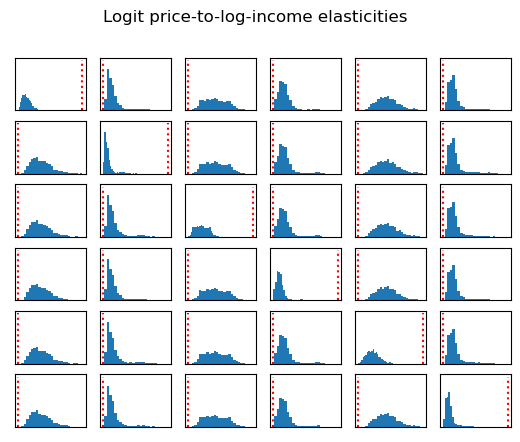

In [ ]:
own_elasticities_logit = {j : (epsilon_logit.reshape((N, J**2))[:,j]).flatten() for j in np.arange(J**2)} # Finds j'th entry in each of the elasticity matrices of individuals i.  

j_pairs = iter.product(np.arange(J), np.arange(J))
num_bins = 25

fig, axes = plt.subplots(J, J)

for p, j in zip(j_pairs, np.arange(J**2)):
    axes[p].hist(own_elasticities_logit[j], num_bins)
    axes[p].vlines(0, 0, 1500, 'red', 'dotted')
    axes[p].get_xaxis().set_visible(False)
    axes[p].get_yaxis().set_visible(False)

fig.suptitle('Logit price-to-log-income elasticities')

plt.show()

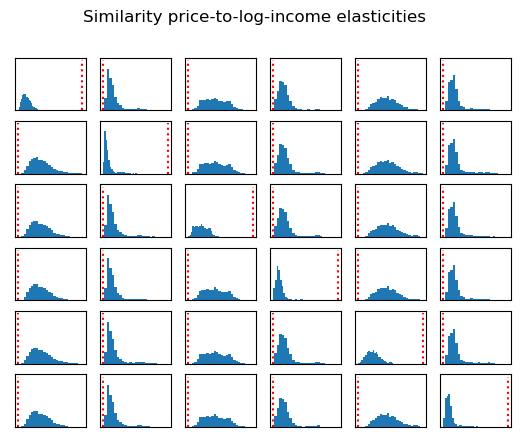

In [ ]:
own_elasticities_similarity = {j : (Epsilon_hat.reshape((N, J**2))[:,j]).flatten() for j in np.arange(J**2)} # Finds j'th entry in each of the elasticity matrices of individuals i.  

j_pairs = iter.product(np.arange(J), np.arange(J))
num_bins = 25

fig, axes = plt.subplots(J, J)

for p, j in zip(j_pairs, np.arange(J**2)):
    axes[p].hist(own_elasticities_similarity[j], num_bins)
    axes[p].vlines(0, 0, 1500, 'red', 'dotted')
    axes[p].get_xaxis().set_visible(False)
    axes[p].get_yaxis().set_visible(False)

fig.suptitle('Similarity price-to-log-income elasticities')

plt.show()

### Diversion ratios for the Similarity model

The diversion ratio to product j from product k is the fraction of consumers leaving product k and switching to product j following a one percent increase in the price of product k. Hence we have:

$$
\mathcal{D}_{jk}^i = -100 \cdot \frac{\partial P_j(u_i|\lambda) / \partial x_{ik\ell}}{\partial P_k(u_i|\lambda) / \partial x_{ik\ell}} = -100 \cdot \frac{\partial P_j(u_i|\lambda) / \partial u_{ik}}{\partial P_k(u_i|\lambda) / \partial u_{ik}}
$$

Where $\mathcal{D}^i = \left( \mathcal{D}_{jk}^i \right)_{j,k \in \{0,1,\ldots ,5\}}$ is the matrix of diversion ratios for individual i. This can be written more compactly as:

$$
\mathcal{D}^i = -100 \cdot \nabla_u P(u|\lambda)(\nabla_u P(u|\lambda) \circ I_J)^{-1}
$$

In [ ]:
def Similarity_diversion(theta, x, q, Psi):
    '''
    '''

    N,C,J = Psi.shape
    K = x.shape[2]

    inv_pertubation_jac = la.inv(Similarity_pertubation_hessian(theta, x, q, Psi))
    qqT = np.einsum('nj,nk->njk', q, q)
    u_jac_ccp = inv_pertubation_jac - qqT
    inv_diag_jac = np.einsum('jk,njk->njk', np.eye(J), 1./u_jac_ccp)

    DR = -100*np.einsum('nlk,nkj->nlj', inv_diag_jac, u_jac_ccp)

    return DR

In [ ]:
DR_hat = Similarity_diversion(Similarity_theta, x, ccp_hat, Psi_hat)
pd.DataFrame(DR_hat[0,:,:])

0           1           2           3           4           5
0 -100.000000   35.071679   24.232985   12.888148   15.405381   12.401807
1   19.524372 -100.000000   30.027869   15.982886   19.086716   15.378157
2   17.224143   38.338462 -100.000000   14.075233   16.822126   13.540035
3   15.320324   34.128100   23.539775 -100.000000   14.959745   12.052057
4   15.711281   34.966313   24.137335   12.834706 -100.000000   12.350365
5   15.249872   33.967610   23.424499   12.467087   14.890932 -100.000000

We now plot the diversion ratios for the $N$ individuals as follows:

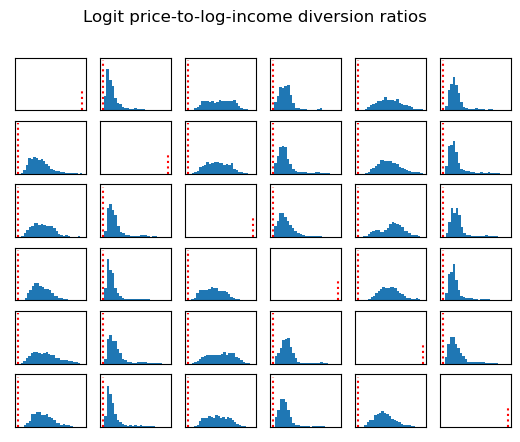

In [ ]:
own_DR_logit = {j : (DR_logit_hat.reshape((N, J**2))[:,j]).flatten() for j in np.arange(J**2)} # Finds j'th entry in each of the elasticity matrices of individuals i.  

j_pairs = iter.product(np.arange(J), np.arange(J))
num_bins = 25

fig, axes = plt.subplots(J, J)

for p, j in zip(j_pairs, np.arange(J**2)):
    axes[p].hist(own_DR_logit[j], num_bins)
    axes[p].vlines(0, 0, 1500, 'red', 'dotted')
    axes[p].get_xaxis().set_visible(False)
    axes[p].get_yaxis().set_visible(False)

fig.suptitle('Logit price-to-log-income diversion ratios')

plt.show()

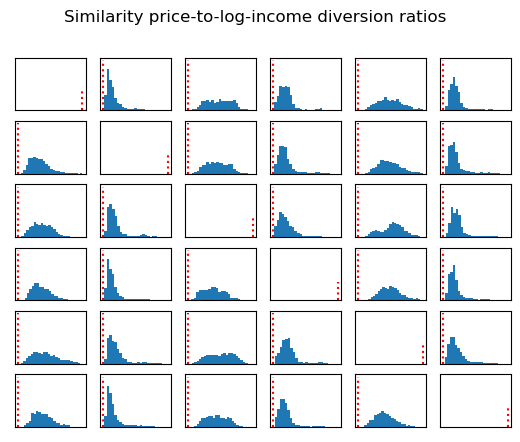

In [ ]:
own_DR_similarity = {j : (DR_hat.reshape((N, J**2))[:,j]).flatten() for j in np.arange(J**2)} # Finds j'th entry in each of the elasticity matrices of individuals i.  

j_pairs = iter.product(np.arange(J), np.arange(J))
num_bins = 25

fig, axes = plt.subplots(J, J)

for p, j in zip(j_pairs, np.arange(J**2)):
    axes[p].hist(own_DR_similarity[j], num_bins)
    axes[p].vlines(0, 0, 1500, 'red', 'dotted')
    axes[p].get_xaxis().set_visible(False)
    axes[p].get_yaxis().set_visible(False)

fig.suptitle('Similarity price-to-log-income diversion ratios')

plt.show()